In [ ]:
 %pip install --upgrade keras

In [ ]:
 %pip install torch torchvision torchaudio

In [ ]:
%pip install scikit-learn pandas matplotlib transformers -U

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.2.0


In [ ]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# №2 Дообучение без замораживания

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_bert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факту',
 'пожара',
 'на',
 'заводе',
 'в',
 'Юг',
 '##ре',
 'заведено',
 'дело',
 '[SEP]']

In [ ]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model_bert(text_ids, output_attentions=False)

In [ ]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 12, 768])

In [ ]:
X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
model_bert = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
class bert_wrapper(keras.Model):
    def __init__(self, model_bert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_bert = keras.layers.TorchModuleWrapper(model_bert)

    def call(self, inputs):
        x = self.model_bert(inputs)
        return x[0]

In [ ]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = bert_wrapper(model_bert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

In [44]:
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=5) # уменьшила кол-во эпох

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:583: UserWarning: Gradients do not exist for variables ['variable_496', 'variable_497'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 3690s 25s/step - accuracy: 0.0846 - loss: 2.8312 - rec_prec: 0.0051 - val_accuracy: 0.4194 - val_loss: 1.9128 - val_rec_prec: 0.1290
Epoch 2/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3619s 25s/step - accuracy: 0.5550 - loss: 1.4502 - rec_prec: 0.3322 - val_accuracy: 0.6452 - val_loss: 0.9471 - val_rec_prec: 0.5806
Epoch 3/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3635s 25s/step - accuracy: 0.9093 - loss: 0.2875 - rec_prec: 0.9794 - val_accuracy: 0.7742 - val_loss: 0.8297 - val_rec_prec: 0.7097
Epoch 4/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3647s 25s/step - accuracy: 0.9956 - loss: 0.0573 - rec_prec: 1.0000 - val_accuracy: 0.8387 - val_loss: 0.7769 - val_rec_prec: 0.8387
Epoch 5/5
144/144 ━━━━━━━━━━━━━━━━━━━━ 3644s 25s/step - accuracy: 0.9980 - loss: 0.0189 - rec_prec: 1.0000 - val_accuracy: 0.8065 - val_loss: 0.8286 - val_rec_prec: 0.8065


dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


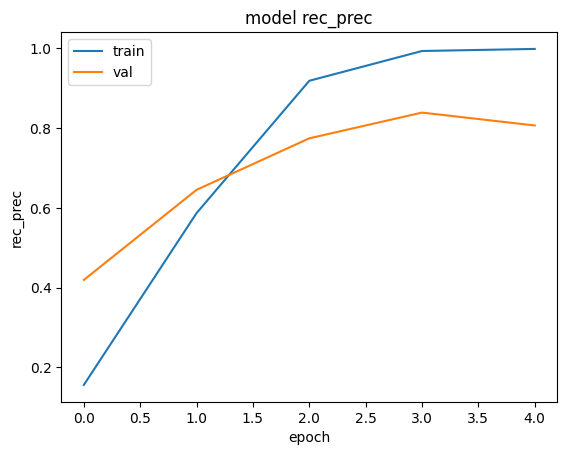

In [45]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [46]:
from sklearn.metrics import classification_report
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step
                   precision    recall  f1-score   support

           Россия       0.00      0.00      0.00         2
              Дом       1.00      1.00      1.00         2
         Из жизни       1.00      1.00      1.00         3
   69-я параллель       0.50      1.00      0.67         1
              Мир       0.50      1.00      0.67         1
  Наука и техника       0.60      1.00      0.75         3
         Ценности       1.00      1.00      1.00         2
Силовые структуры       0.50      0.50      0.50         2
   Интернет и СМИ       1.00      0.50      0.67         2
        Экономика       0.67      1.00      0.80         2
             Крым       0.00      0.00      0.00         0
      Бывший СССР       1.00      1.00      1.00         3
       Библиотека       0.00      0.00      0.00         0
         Культура       1.00      0.67      0.80         3
            Спорт       1.00      0.50      0.67         2
           Бизнес 